# 2. Environment Setup and Verification

2.1 Python Libraries Import

As a next step let's import the libraries needed throughout:


In [1]:
# importing utilities
import os
import sys
from datetime import datetime

# importing data science libraries
import pandas as pd
import random as rd
import numpy as np

# importing pytorch libraries
import torch
from torch import nn
from torch import autograd
from torch.utils.data import DataLoader

# import visualization libraries
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import seaborn as sns
from IPython.display import Image, display
sns.set_style('darkgrid')

# ignore potential warnings
import warnings
warnings.filterwarnings("ignore")

# Allow for Jupyter notebook inline plotting:
%matplotlib inline 

# 2.2 CUDNN and GPU Verification

To determine if CDNN is available on the server let's execute the cell below to display information about the available CUDNN version:


In [20]:
# print CUDNN backend version
now = datetime.utcnow().strftime("%Y%m%d-%H:%M:%S")
print('[LOG {}] The CUDNN backend version: {}'.format(now, torch.backends.cudnn.version()))
     
# If CUDNN and GPU's are available let's still specify if we want to use both:
USE_CUDA = True
     


[LOG 20240709-11:13:09] The CUDNN backend version: None


# 2.3 Python and PyTorch Verification

Let's execute the cell below to display information about the Python and PyTorch version running on the server:


In [21]:
# print current Python version
now = datetime.utcnow().strftime("%Y%m%d-%H:%M:%S")
print('[LOG {}] The Python version: {}'.format(now, sys.version))
     

[LOG 20240709-11:13:09] The Python version: 3.8.15 | packaged by conda-forge | (default, Nov 22 2022, 08:51:59) 
[Clang 14.0.6 ]


In [22]:
# print current PyTorch version
now = datetime.utcnow().strftime("%Y%m%d-%H:%M:%S")
print('[LOG {}] The PyTorch version: {}'.format(now, torch.__version__))

[LOG 20240709-11:13:09] The PyTorch version: 1.13.0


# 2.4 Random Seed Initialization

Finally, let' set the seeds of random elements in the code e.g. the initialization of the network parameters to guarantee deterministic computation and results:


In [23]:
# init deterministic seed
seed_value = 1234 #4444 #3333 #2222 #1111 #1234
rd.seed(seed_value) # set random seed
np.random.seed(seed_value) # set numpy seed
torch.manual_seed(seed_value) # set pytorch seed CPU
if (torch.backends.cudnn.version() != None and USE_CUDA == True):
    torch.cuda.manual_seed(seed_value) # set pytorch seed GPU

#  3. Financial Fraud Detection Dataset

In this section, we will conduct a descriptive analysis of the labs financial dataset. Furthermore, we will apply some necessary pre-processing steps to train a deep neural network.

Let's start loading the dataset and investigate its structure and attributes:


In [24]:
data= pd.read_csv('Fraud Dataset.csv')
print(data.shape)
data.head()

(533009, 10)


,BELNR,WAERS,BUKRS,KTOSL,PRCTR,BSCHL,HKONT,DMBTR,WRBTR,label
0,288203,C3,C31,C9,C92,A3,B1,280979.60,0.00,regular
1,324441,C1,C18,C7,C76,A1,B2,129856.53,243343.00,regular
2,133537,C1,C19,C2,C20,A1,B3,957463.97,3183838.41,regular
3,331521,C4,C48,C9,C95,A2,B1,2681709.51,28778.00,regular
4,375333,C5,C58,C1,C19,A3,B1,910514.49,346.00,regular


In [25]:
from sklearn.preprocessing import LabelEncoder


# Apply LabelEncoder to all categorical columns
data[data.select_dtypes(include=['object']).columns] = data.select_dtypes(include=['object']).apply(LabelEncoder().fit_transform)

data.head()

,BELNR,WAERS,BUKRS,KTOSL,PRCTR,BSCHL,HKONT,DMBTR,WRBTR,label
0,288203,5,25,15,86,3,1,280979.60,0.00,2
1,324441,3,12,11,70,0,2,129856.53,243343.00,2
2,133537,3,13,5,14,0,3,957463.97,3183838.41,2
3,331521,6,42,15,89,2,1,2681709.51,28778.00,2
4,375333,7,52,4,13,3,1,910514.49,346.00,2


# 
3.1 Initial Data and Attribute Assessment

The dataset was augmented and renamed the attributes to appear more similar to a real-world dataset that one usually observes in SAP-ERP systems as part of SAP's Finance and Cost controlling (FICO) module.

The dataset contains a subset of in total 7 categorical and 2 numerical attributes available in the FICO BKPF (containing the posted journal entry headers) and BSEG (containing the posted journal entry segments) tables. Please, find below a list of the individual attributes as well as a brief description of their respective semantics:

        BELNR: the accounting document number,
        BUKRS: the company code,
        BSCHL: the posting key,
        HKONT: the posted general ledger account,
        PRCTR: the posted profit center,
        WAERS: the currency key,
        KTOSL: the general ledger account key,
        DMBTR: the amount in local currency,
        WRBTR: the amount in document currency.

Let's also have a closer look into the top 10 rows of the dataset:


You may also have noticed the attribute label in the data. We will use this field throughout the lab to evaluate the quality of our trained models. The field describes the true nature of each individual transaction of either being a regular transaction (denoted by regular) or an anomaly (denoted by global and local). Let's have closer look into the distribution of the regular vs. anomalous transactions in the dataset:

In [26]:
# number of anomalies vs. regular transactions
data.label.value_counts()

label
2    532909
0        70
1        30
Name: count, dtype: int64

In [33]:
label=data['label']

Ok, the statistic reveals that, similar to real world scenarios, we are facing a highly "unbalanced" dataset. Overall, the dataset contains only a small fraction of 100 (0.018%) anomalous transactions. While the 100 anomalous entries encompass 70 (0.013%) "global" anomalies and 30 (0.005%) "local" anomalies as introduced in section 1.2.

# remove the "ground-truth" label information for the following steps of the lab
label = data.pop('label')
# inspect top rows of dataset
data.head(10)


# 3.2 Pre-Processing of Categorical Transaction Attributes

From the initial data assessment above we can observe that the majority of attributes recorded in AIS- and ERP-systems correspond to categorical (discrete) attribute values, e.g. the posting date, the general-ledger account, the posting type, the currency. Let's have a more detailed look into the distribution of two dataset attributes, namely (1) the posting key BSCHL as well as (2) the general ledger account HKONT:


Text(0.5, 1.0, 'Distribution of HKONT attribute values')

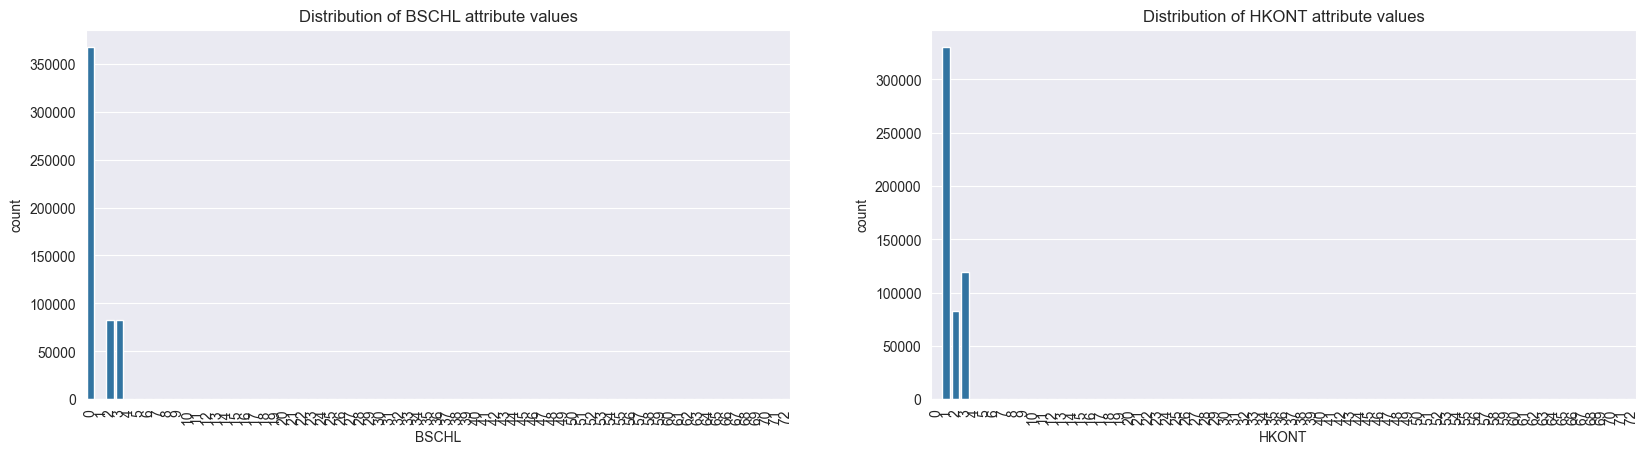

In [10]:
# prepare to plot posting key and general ledger account side by side
fig, ax = plt.subplots(1,2)
fig.set_figwidth(20)

# plot the distribution of the posting key attribute
g = sns.countplot(x=data['BSCHL'], ax=ax[0])
g.set_xticklabels(g.get_xticklabels(), rotation=90)
g.set_title('Distribution of BSCHL attribute values')

# plot the distribution of the general ledger account attribute
g = sns.countplot(x=data['HKONT'], ax=ax[1])
g.set_xticklabels(g.get_xticklabels(), rotation=90)
g.set_title('Distribution of HKONT attribute values')

Unfortunately, neural networks are in general not designed to be trained directly on categorical data and require the attributes to be trained on to be numeric. One simple way to meet this requirement is by applying a technique referred to as "one-hot" encoding. Using this encoding technique, we will derive a numerical representation of each of the categorical attribute values. One-hot encoding creates new binary columns for each categorical attribute value present in the original data.

Let's work through a brief example: The categorical attribute “Receiver” below contains the names "John", "Timur" and "Marco". We "one-hot" encode the names by creating a separate binary column for each possible name value observable in the "Receiver" column. Now, we encode for each transaction that contains the value "John" in the "Receiver" column this observation with 1.0 in the newly created "John" column and 0.0 in all other created name columns.

Using this technique will "one-hot" encode the 6 categorical attributes in the original transactional dataset. This can be achieved using the get_dummies() function available in the Pandas data science library:

# select categorical attributes to be "one-hot" encoded
categorical_attr_names = ['KTOSL', 'PRCTR', 'BSCHL', 'HKONT','WAERS', 'BUKRS']

# encode categorical attributes into a binary one-hot encoded representation 
data_categ_transformed = pd.get_dummies(data[categorical_attr_names])    

Finally, let's inspect the encoding of 10 sample transactions to see if we have been successfull.

# inspect encoded sample transactions
data_categ_transformed.head(10)

# 3.2 Pre-Processing of Numerical Transaction Attributes

Let's now inspect the distributions of the two numerical attributes contained in the transactional dataset namely, the (1) local currency amount DMBTR and the (2) document currency amount WRBTR:

Text(0.5, 1.0, 'Distribution of WRBTR amount values')

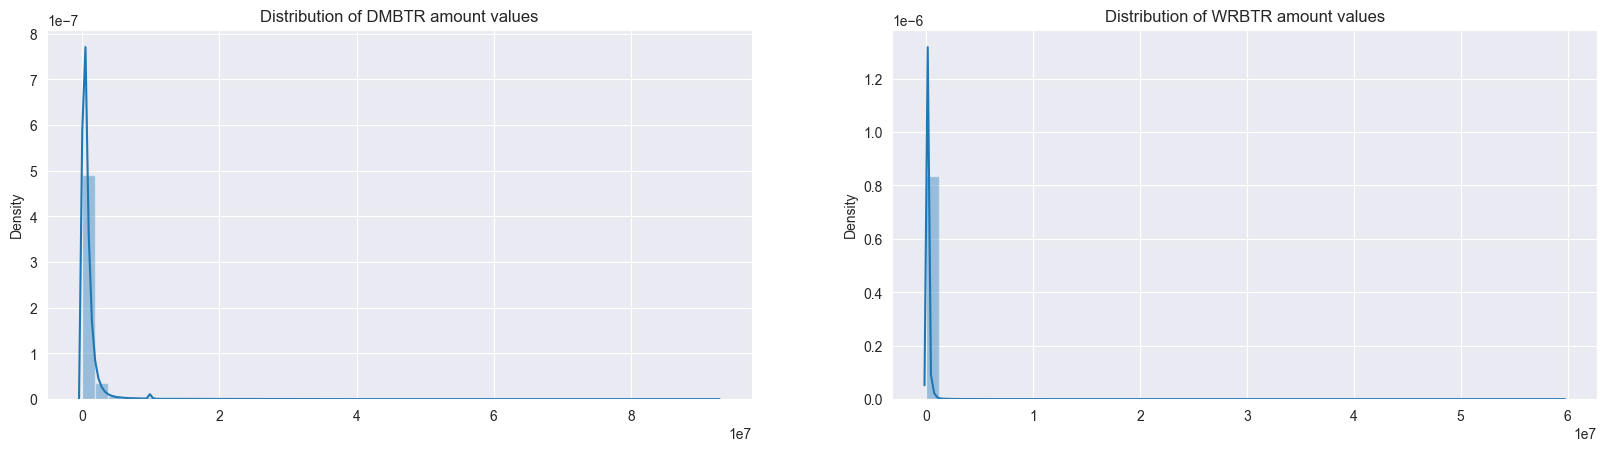

In [11]:
# plot the log-scaled "DMBTR" as well as the "WRBTR" attribute value distribution
fig, ax = plt.subplots(1,2)
fig.set_figwidth(20)

# plot distribution of the local amount attribute
g = sns.distplot(data['DMBTR'].tolist(), ax=ax[0])
g.set_title('Distribution of DMBTR amount values')

# plot distribution of the document amount attribute
g = sns.distplot(data['WRBTR'].tolist(), ax=ax[1])
g.set_title('Distribution of WRBTR amount values')    

As expected, it can be observed, that for both attributes the distributions of amount values are heavy tailed. In order to approach faster a potential global minimum scaling and normalization of numerical input values is good a practice. Therefore, we first log-scale both variables and second min-max normalize the scaled amounts to the interval [0, 1].

In [37]:
# select "DMBTR" vs. "WRBTR" attribute
numeric_attr_names = [ 'DMBTR','WRBTR']

# add a small epsilon to eliminate zero values from data for log scaling
numeric_attr = data[numeric_attr_names] + 1e-7
numeric_attr = numeric_attr.apply(np.log)

# normalize all numeric attributes to the range [0,1]
data_numeric_attr = (numeric_attr - numeric_attr.min()) / (numeric_attr.max() - numeric_attr.min())

Let's now visualize the log-scaled and min-max normalized distributions of both attributes:

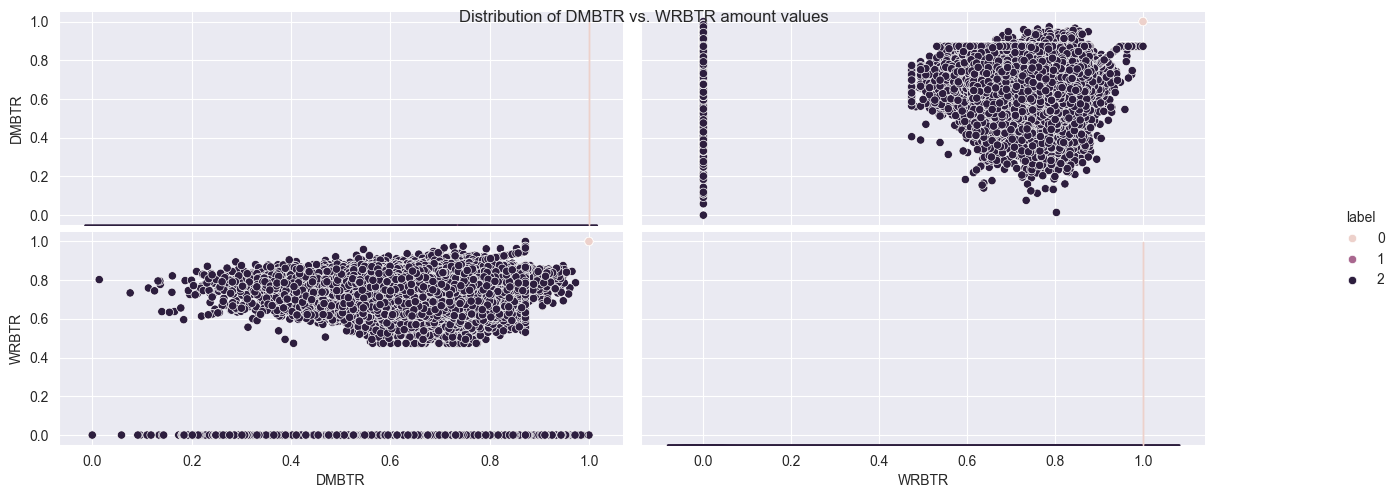

In [38]:
# append 'label' attribute for colour distinction
numeric_attr_vis = data_numeric_attr.copy()
numeric_attr_vis['label'] = label

# plot the log-scaled and min-max normalized numeric attributes
g = sns.pairplot(data=numeric_attr_vis, vars=numeric_attr_names, hue='label')
g.fig.suptitle('Distribution of DMBTR vs. WRBTR amount values')
g.fig.set_size_inches(15, 5)

Ok, as anticipated the numeric attribute values of the "global" anomalies (green) fall outside the range of the regular amount distributions due to their unusual high amount values. In contrast, the numeric attribute values of the "local" anomalies (orange) are much more commingled within the regular transaction amounts

# 3.3 Merge Categorical and Numerical Transaction Attributes

Finally, we merge both pre-processed numerical and categorical attributes into a single dataset that we will use for training our deep autoencoder neural network (explained an implemented in the following section 4.):

In [40]:
# merge categorical and numeric subsets
data2= pd.concat([data[['WAERS', 'BUKRS', 'KTOSL', 'PRCTR', 'BSCHL', 'HKONT']], data_numeric_attr], axis = 1)
data2.head()   

,WAERS,BUKRS,KTOSL,PRCTR,BSCHL,HKONT,DMBTR,WRBTR
0,5,25,15,86,3,1,0.666635,0.000000
1,3,12,11,70,0,2,0.622241,0.838315
2,3,13,5,14,0,3,0.737149,0.913897
3,6,42,15,89,2,1,0.796386,0.775564
4,7,52,4,13,3,1,0.734257,0.645617


In [41]:
X,y=data2, label

Now, let's again have a look at the dimensionality of the dataset after we applied the distinct pre-processing steps to the attributes:


In [42]:
# inspect final dimensions of pre-processed transactional data
# ori_subset_transformed = ori_subset_transformed.sample(frac=0.50)
data2.shape

(533009, 8)

In [43]:
import gc

gc.collect()

2422

In [45]:
data2.head()

,WAERS,BUKRS,KTOSL,PRCTR,BSCHL,HKONT,DMBTR,WRBTR
0,5,25,15,86,3,1,0.666635,0.000000
1,3,12,11,70,0,2,0.622241,0.838315
2,3,13,5,14,0,3,0.737149,0.913897
3,6,42,15,89,2,1,0.796386,0.775564
4,7,52,4,13,3,1,0.734257,0.645617


In [46]:
X.head()

,WAERS,BUKRS,KTOSL,PRCTR,BSCHL,HKONT,DMBTR,WRBTR
0,5,25,15,86,3,1,0.666635,0.000000
1,3,12,11,70,0,2,0.622241,0.838315
2,3,13,5,14,0,3,0.737149,0.913897
3,6,42,15,89,2,1,0.796386,0.775564
4,7,52,4,13,3,1,0.734257,0.645617


y = y.replace({'regular': 0, 'global': 1,'local': 2})

In [50]:
# split the data into training and testing sets
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)

#print(f"Dataset: {dataset_name}")
print(f"Training set shape: {X_train.shape}")
print(f"Test set shape: {X_test.shape}")

Training set shape: (373106, 8)
Test set shape: (159903, 8)


# Importing AD models from PyOD

In [21]:
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import roc_auc_score
from pyod.models.knn import KNN
from pyod.models.lof import LOF
from pyod.models.hbos import HBOS
from pyod.models.iforest import IForest
from pyod.models.pca import PCA
from pyod.models.mcd import MCD
from pyod.models.ocsvm import OCSVM
from pyod.models.abod import ABOD
from pyod.models.auto_encoder import AutoEncoder
from pyod.models.vae import VAE
from pyod.models.lscp import LSCP
from pyod.models.cof import COF
from pyod.models.loci import LOCI
from pyod.models.sod import SOD
from pyod.models.kde import KDE

In [ ]:
# Initialize a PyOD model (KNN as an example)
clf = KNN()
# Train the model
clf.fit(X_train)

# Predict anomalies on the test set
y_test_pred = clf.predict(X_test)
y_test_scores = clf.decision_function(X_test)

In [62]:
from sklearn.metrics import roc_auc_score, accuracy_score

# Evaluate the model
#auc = roc_auc_score(y_test, y_test_scores,multi_class='ovr')
accuracy = accuracy_score(y_test, y_test_pred)
#auc_knn=auc
accuracy_knn=accuracy
#print(f"ROC AUC: {auc:.4f}")
print(f"Accuracy: {accuracy:.4f}")

Accuracy: 0.0001


In [ ]:
from sklearn.metrics import roc_auc_score, accuracy_score

# Example data
# Assuming y_test contains your true labels and y_test_scores contains your predicted scores

# Evaluate the model for multi-class classification
try:
    auc = roc_auc_score(np.array(y_test), y_test_scores, multi_class='ovr')
    accuracy = accuracy_score(y_test, y_test_pred)
    auc_knn = auc
    accuracy_knn = accuracy
    print(f"ROC AUC: {auc:.4f}")
    print(f"Accuracy: {accuracy:.4f}")
except Exception as e:
    print(f"Error: {e}")

In [2]:
import pandas as pd

# Load the dataset
df = pd.read_csv("creditcard.csv")

# Check the shape of the dataset
print("Shape of the dataset:", df.shape)

# Check the first few rows of the dataset
df.head()

Shape of the dataset: (284807, 31)


,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


In [3]:
#Check if there are any missing values in the dataset
print(df.isnull().sum())

Time      0
V1        0
V2        0
V3        0
V4        0
V5        0
V6        0
V7        0
V8        0
V9        0
V10       0
V11       0
V12       0
V13       0
V14       0
V15       0
V16       0
V17       0
V18       0
V19       0
V20       0
V21       0
V22       0
V23       0
V24       0
V25       0
V26       0
V27       0
V28       0
Amount    0
Class     0
dtype: int64


In [4]:
from sklearn.preprocessing import StandardScaler

# Scale the Amount column
df['Amount'] = StandardScaler().fit_transform(df['Amount'].values.reshape(-1, 1))

# Scale the Time column
df['Time'] = StandardScaler().fit_transform(df['Time'].values.reshape(-1, 1))

# Check the first few rows of the dataset after scaling
df.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,-1.996583,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,0.244964,0
1,-1.996583,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,-0.342475,0
2,-1.996562,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,1.160686,0
3,-1.996562,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,0.140534,0
4,-1.996541,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,-0.073403,0


In [12]:
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import RandomOverSampler, SMOTE
# Define X and y
X = df.drop('Class', axis=1)
y = df['Class']
# Split the dataset into training and testing sets
# Split the dataset into training and testing sets
# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42,stratify=y)

In [13]:
smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)

In [14]:
from flaml import AutoML

automl = AutoML()

# Specify automl goal and constraint
automl_settings = {
    "time_budget": 200,       # total running time in seconds
    "task": 'classification', # task type
    "seed": 24545678,         # random seed
    "metric": 'roc_auc',      # use ROC AUC as the metric
}

# Fit the AutoML model with the specified settings
automl.fit(X_train=X_train, y_train=y_train, **automl_settings)

[flaml.automl.logger: 07-10 07:56:23] {1680} INFO - task = classification
[flaml.automl.logger: 07-10 07:56:23] {1691} INFO - Evaluation method: holdout
[flaml.automl.logger: 07-10 07:56:24] {1789} INFO - Minimizing error metric: 1-roc_auc
[flaml.automl.logger: 07-10 07:56:24] {1901} INFO - List of ML learners in AutoML Run: ['lgbm', 'rf', 'xgboost', 'extra_tree', 'xgb_limitdepth', 'lrl1']
[flaml.automl.logger: 07-10 07:56:24] {2219} INFO - iteration 0, current learner lgbm
[flaml.automl.logger: 07-10 07:56:24] {2345} INFO - Estimated sufficient time budget=12278s. Estimated necessary time budget=283s.
[flaml.automl.logger: 07-10 07:56:24] {2392} INFO -  at 2.5s,	estimator lgbm's best error=0.0486,	best estimator lgbm's best error=0.0486
[flaml.automl.logger: 07-10 07:56:24] {2219} INFO - iteration 1, current learner lgbm
[flaml.automl.logger: 07-10 07:56:24] {2392} INFO -  at 2.6s,	estimator lgbm's best error=0.0486,	best estimator lgbm's best error=0.0486
[flaml.automl.logger: 07-10 

[flaml.automl.logger: 07-10 07:56:28] {2219} INFO - iteration 34, current learner lgbm
[flaml.automl.logger: 07-10 07:56:30] {2392} INFO -  at 8.7s,	estimator lgbm's best error=0.0050,	best estimator lgbm's best error=0.0050
[flaml.automl.logger: 07-10 07:56:30] {2219} INFO - iteration 35, current learner rf
[flaml.automl.logger: 07-10 07:56:30] {2392} INFO -  at 9.0s,	estimator rf's best error=0.0304,	best estimator lgbm's best error=0.0050
[flaml.automl.logger: 07-10 07:56:30] {2219} INFO - iteration 36, current learner extra_tree
[flaml.automl.logger: 07-10 07:56:30] {2392} INFO -  at 9.1s,	estimator extra_tree's best error=0.0455,	best estimator lgbm's best error=0.0050
[flaml.automl.logger: 07-10 07:56:30] {2219} INFO - iteration 37, current learner rf
[flaml.automl.logger: 07-10 07:56:31] {2392} INFO -  at 9.3s,	estimator rf's best error=0.0304,	best estimator lgbm's best error=0.0050
[flaml.automl.logger: 07-10 07:56:31] {2219} INFO - iteration 38, current learner extra_tree
[fl

[flaml.automl.logger: 07-10 07:56:49] {2219} INFO - iteration 69, current learner lgbm
[flaml.automl.logger: 07-10 07:56:51] {2392} INFO -  at 29.7s,	estimator lgbm's best error=0.0035,	best estimator lgbm's best error=0.0035
[flaml.automl.logger: 07-10 07:56:51] {2219} INFO - iteration 70, current learner xgb_limitdepth
[flaml.automl.logger: 07-10 07:56:52] {2392} INFO -  at 30.8s,	estimator xgb_limitdepth's best error=0.0247,	best estimator lgbm's best error=0.0035
[flaml.automl.logger: 07-10 07:56:52] {2219} INFO - iteration 71, current learner xgb_limitdepth
[flaml.automl.logger: 07-10 07:56:53] {2392} INFO -  at 31.7s,	estimator xgb_limitdepth's best error=0.0247,	best estimator lgbm's best error=0.0035
[flaml.automl.logger: 07-10 07:56:53] {2219} INFO - iteration 72, current learner extra_tree
[flaml.automl.logger: 07-10 07:56:53] {2392} INFO -  at 32.1s,	estimator extra_tree's best error=0.0189,	best estimator lgbm's best error=0.0035
[flaml.automl.logger: 07-10 07:56:53] {2219}

[flaml.automl.logger: 07-10 07:59:23] {2219} INFO - iteration 105, current learner extra_tree
[flaml.automl.logger: 07-10 07:59:24] {2392} INFO -  at 182.8s,	estimator extra_tree's best error=0.0141,	best estimator lgbm's best error=0.0018
[flaml.automl.logger: 07-10 07:59:24] {2219} INFO - iteration 106, current learner rf
[flaml.automl.logger: 07-10 07:59:27] {2392} INFO -  at 185.3s,	estimator rf's best error=0.0304,	best estimator lgbm's best error=0.0018
[flaml.automl.logger: 07-10 07:59:27] {2219} INFO - iteration 107, current learner extra_tree
[flaml.automl.logger: 07-10 07:59:27] {2392} INFO -  at 185.8s,	estimator extra_tree's best error=0.0141,	best estimator lgbm's best error=0.0018
[flaml.automl.logger: 07-10 07:59:27] {2219} INFO - iteration 108, current learner xgb_limitdepth
[flaml.automl.logger: 07-10 07:59:29] {2392} INFO -  at 187.8s,	estimator xgb_limitdepth's best error=0.0201,	best estimator lgbm's best error=0.0018
[flaml.automl.logger: 07-10 07:59:29] {2219} INF

0.9994733330992591


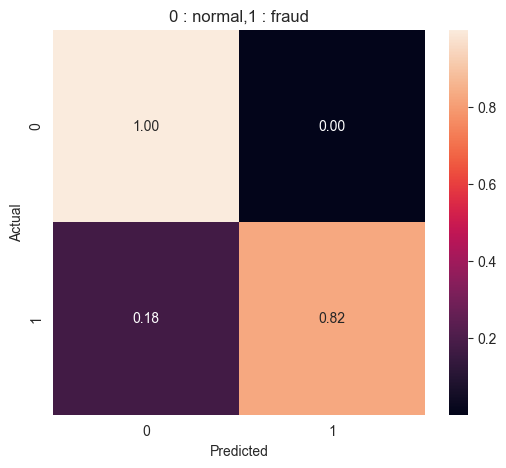

In [25]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_auc_score, accuracy_score
import seaborn as sns 
pred=automl.predict (X_test)
y_test_scores = automl.predict_proba(X_test)
accuracy = accuracy_score(y_test, pred)
print(accuracy)
cm = confusion_matrix(y_test, pred)
# Normalise
cmn = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
fig, ax = plt.subplots(figsize=(6,5))
sns.heatmap(cmn, annot=True, fmt='.2f')
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.title('0 : normal,1 : fraud')
plt.show(block=False)

In [17]:
from flaml import AutoML
automl = AutoML()
# Specify automl goal and constraint
automl_settings = {
    "time_budget": 200,  # total running time in seconds
    "task": 'classification',  # task type
    "seed": 24545678,  # random seed
    "metric" : 'accuracy'}
automl.fit(X_train=X_train_resampled, y_train=y_train_resampled, **automl_settings)

[flaml.automl.logger: 07-10 08:02:48] {1680} INFO - task = classification
[flaml.automl.logger: 07-10 08:02:48] {1691} INFO - Evaluation method: holdout
[flaml.automl.logger: 07-10 08:02:49] {1789} INFO - Minimizing error metric: 1-accuracy
[flaml.automl.logger: 07-10 08:02:49] {1901} INFO - List of ML learners in AutoML Run: ['lgbm', 'rf', 'xgboost', 'extra_tree', 'xgb_limitdepth', 'lrl1']
[flaml.automl.logger: 07-10 08:02:49] {2219} INFO - iteration 0, current learner lgbm
[flaml.automl.logger: 07-10 08:02:49] {2345} INFO - Estimated sufficient time budget=33821s. Estimated necessary time budget=780s.
[flaml.automl.logger: 07-10 08:02:49] {2392} INFO -  at 5.7s,	estimator lgbm's best error=0.0634,	best estimator lgbm's best error=0.0634
[flaml.automl.logger: 07-10 08:02:49] {2219} INFO - iteration 1, current learner lgbm
[flaml.automl.logger: 07-10 08:02:49] {2392} INFO -  at 5.7s,	estimator lgbm's best error=0.0634,	best estimator lgbm's best error=0.0634
[flaml.automl.logger: 07-10

[flaml.automl.logger: 07-10 08:03:02] {2219} INFO - iteration 34, current learner lgbm
[flaml.automl.logger: 07-10 08:03:07] {2392} INFO -  at 24.0s,	estimator lgbm's best error=0.0030,	best estimator lgbm's best error=0.0030
[flaml.automl.logger: 07-10 08:03:07] {2219} INFO - iteration 35, current learner xgboost
[flaml.automl.logger: 07-10 08:03:07] {2392} INFO -  at 24.1s,	estimator xgboost's best error=0.0469,	best estimator lgbm's best error=0.0030
[flaml.automl.logger: 07-10 08:03:07] {2219} INFO - iteration 36, current learner extra_tree
[flaml.automl.logger: 07-10 08:03:08] {2392} INFO -  at 24.3s,	estimator extra_tree's best error=0.0785,	best estimator lgbm's best error=0.0030
[flaml.automl.logger: 07-10 08:03:08] {2219} INFO - iteration 37, current learner xgboost
[flaml.automl.logger: 07-10 08:03:08] {2392} INFO -  at 24.5s,	estimator xgboost's best error=0.0217,	best estimator lgbm's best error=0.0030
[flaml.automl.logger: 07-10 08:03:08] {2219} INFO - iteration 38, curren

[flaml.automl.logger: 07-10 08:03:41] {2392} INFO -  at 58.2s,	estimator lgbm's best error=0.0028,	best estimator lgbm's best error=0.0028
[flaml.automl.logger: 07-10 08:03:41] {2219} INFO - iteration 70, current learner lrl1
[flaml.automl.logger: 07-10 08:03:42] {2392} INFO -  at 58.9s,	estimator lrl1's best error=0.0439,	best estimator lgbm's best error=0.0028
[flaml.automl.logger: 07-10 08:03:42] {2219} INFO - iteration 71, current learner lrl1
[flaml.automl.logger: 07-10 08:03:43] {2392} INFO -  at 59.4s,	estimator lrl1's best error=0.0439,	best estimator lgbm's best error=0.0028
[flaml.automl.logger: 07-10 08:03:43] {2219} INFO - iteration 72, current learner lrl1
[flaml.automl.logger: 07-10 08:03:43] {2392} INFO -  at 59.9s,	estimator lrl1's best error=0.0437,	best estimator lgbm's best error=0.0028
[flaml.automl.logger: 07-10 08:03:43] {2219} INFO - iteration 73, current learner rf
[flaml.automl.logger: 07-10 08:03:43] {2392} INFO -  at 60.2s,	estimator rf's best error=0.0144,	b

[flaml.automl.logger: 07-10 08:04:08] {2219} INFO - iteration 105, current learner extra_tree
[flaml.automl.logger: 07-10 08:04:09] {2392} INFO -  at 85.4s,	estimator extra_tree's best error=0.0022,	best estimator lgbm's best error=0.0009
[flaml.automl.logger: 07-10 08:04:09] {2219} INFO - iteration 106, current learner extra_tree
[flaml.automl.logger: 07-10 08:04:09] {2392} INFO -  at 85.8s,	estimator extra_tree's best error=0.0014,	best estimator lgbm's best error=0.0009
[flaml.automl.logger: 07-10 08:04:09] {2219} INFO - iteration 107, current learner extra_tree
[flaml.automl.logger: 07-10 08:04:09] {2392} INFO -  at 86.0s,	estimator extra_tree's best error=0.0014,	best estimator lgbm's best error=0.0009
[flaml.automl.logger: 07-10 08:04:09] {2219} INFO - iteration 108, current learner extra_tree
[flaml.automl.logger: 07-10 08:04:10] {2392} INFO -  at 87.0s,	estimator extra_tree's best error=0.0011,	best estimator lgbm's best error=0.0009
[flaml.automl.logger: 07-10 08:04:10] {2219}

[flaml.automl.logger: 07-10 08:05:52] {2392} INFO -  at 188.5s,	estimator rf's best error=0.0047,	best estimator lgbm's best error=0.0002
[flaml.automl.logger: 07-10 08:05:52] {2219} INFO - iteration 141, current learner rf
[flaml.automl.logger: 07-10 08:05:53] {2392} INFO -  at 189.6s,	estimator rf's best error=0.0047,	best estimator lgbm's best error=0.0002
[flaml.automl.logger: 07-10 08:05:53] {2219} INFO - iteration 142, current learner xgb_limitdepth
[flaml.automl.logger: 07-10 08:05:53] {2392} INFO -  at 189.8s,	estimator xgb_limitdepth's best error=0.0062,	best estimator lgbm's best error=0.0002
[flaml.automl.logger: 07-10 08:05:53] {2219} INFO - iteration 143, current learner xgboost
[flaml.automl.logger: 07-10 08:05:53] {2392} INFO -  at 189.9s,	estimator xgboost's best error=0.0039,	best estimator lgbm's best error=0.0002
[flaml.automl.logger: 07-10 08:05:53] {2219} INFO - iteration 144, current learner xgb_limitdepth
[flaml.automl.logger: 07-10 08:05:53] {2392} INFO -  at 19

0.9994733330992591


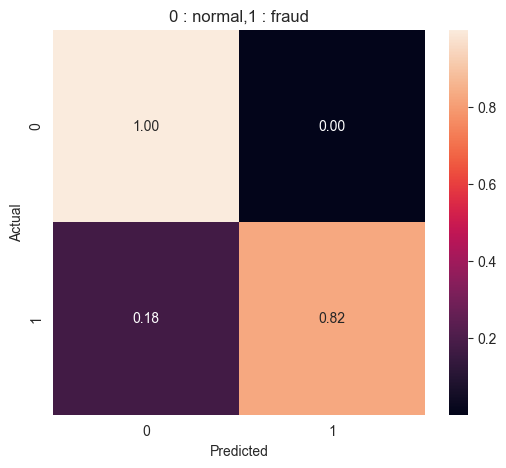

In [19]:
from sklearn.metrics import confusion_matrix
import seaborn as sns 
pred=automl.predict (X_test)
y_test_scores = automl.decision_function(X_test)
accuracy = accuracy_score(y_test, pred)
print(accuracy)
cm = confusion_matrix(y_test, pred)
# Normalise
cmn = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
fig, ax = plt.subplots(figsize=(6,5))
sns.heatmap(cmn, annot=True, fmt='.2f')
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.title('0 : normal,1 : fraud')
plt.show(block=False)